# Use VICET to Bound Odometry Errors in LOAM initialized from a moving platform

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-21 15:49:07.353434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:07.444687: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 15:49:07.834756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-21 15:49:07.834810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-21 15:49:08.503641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:08.504394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


## Load HD Map from .ply File

In [2]:
import trimesh
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]

print(np.shape(submap))
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load "Ground Truth" Poses provided in dataset

In [255]:
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #Kitware API specify offset as -134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
poses_eul = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# print(poses_eul)

<IPython.core.display.Javascript object>


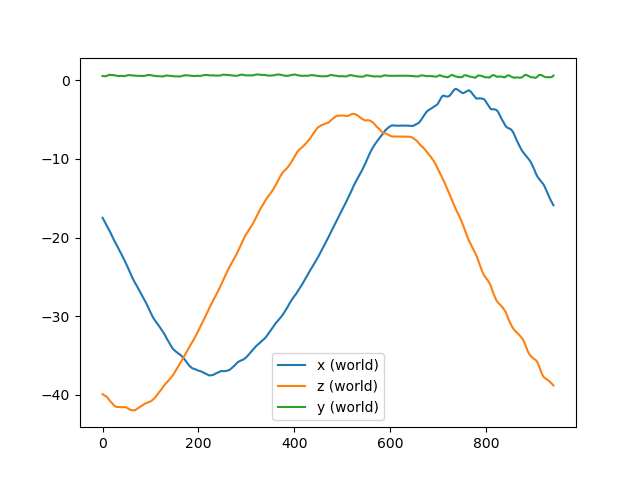

In [256]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
start_idx = 2400
end_idx = 3341

#plot GT
ax.plot(poses[start_idx:end_idx,:3,3], label={'x (world)',"y (world)","z (world)"})
# ax.plot(np.diff(poses[start_idx:end_idx,:3,3], axis = 0), label={'x',"y","z"})
# ax.plot(poses_eul)
# ax.plot(np.diff(poses_eul, axis=0))
ax.legend(loc="best")

## Load LOAM results (starting at arbitrary scan idx) and plot against ground truth

#### NOTE: axis will not be aligned!!!

<IPython.core.display.Javascript object>


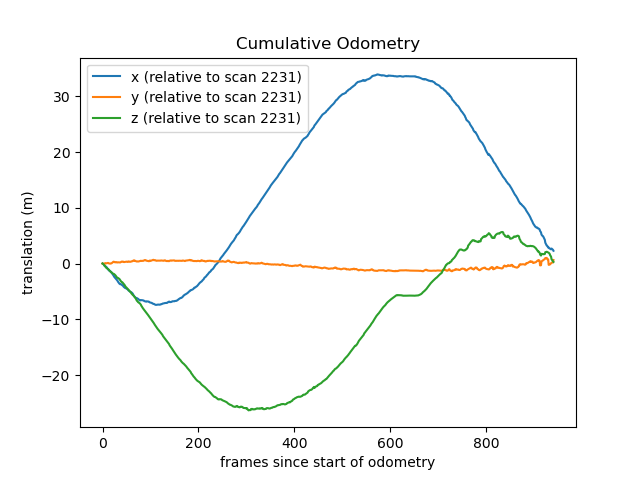

In [541]:
# fn = "results/LOAM/05_test1.npy" #before I got mapmaker working
# fn = "results/LOAM/05_test2.npy" #before I got mapmaker working

# 05_01 after reinstalling EVERYTHING and compiling pcl-1.10 from source
# fn = "results/LOAM/05_test3.npy" # 1650 long 
#makes odom estimates for overall frames 1690-3340 

# # rosbag play --clock -s 54 -r 0.05 rooster_2020-07-10-09-16-39_1.bag 
# fn = "results/LOAM/05_test4.npy" 

# # rosbag play --clock -s 55 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test5.npy" #1100 frames long, starts at 2241 

# start at 2400- very obvious forward motion distortion ()
# rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
fn = "results/LOAM/05_test6.npy" #playback at 0.05x speed
# fn = "results/LOAM/05_test7.npy" #playback at 0.2x speed
# fn_fast = "results/LOAM/05_test8.npy" #playback at 1.0x speed (bad)

LOAM_traj = np.load(fn)
# LOAM_traj = np.diff(np.load(fn), axis = 0)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,1], label = "y (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
ax.set_title("Cumulative Odometry")
ax.set_xlabel("frames since start of odometry")
ax.set_ylabel("translation (m)")
ax.legend(loc="best")

# Plot GT and LOAM in 3D against HD Map 

### TODO: center map about first point in LOAM trajectory

In [542]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [543]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# start_idx = 2400 #overall of GT that corresponds to scan where LOAM begins
# end_idx = #3341
start_idx = 2392
# start_idx = 2241
end_idx = start_idx + len(LOAM_traj) #3341

#draw HD Map -------------------------------------------
# disp.append(Points(submap, c = "grey", r = 2, alpha = 0.1))

submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314

#draw ground truth trajectory -------------------------
# disp.append(Points(gt[start_idx:end_idx,2:5], c = "purple", r=3))#, alpha = 0.2)) #for debug

#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (initial_pose @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
disp.append(Points(gt_lidarframe[start_idx:end_idx,:3], c = "blue", r=3))#, alpha = 0.2))

#draw arrows showand provideding heading
for i in range(start_idx, end_idx,25):
    rot_m = R.from_quat(gt[i,5:]).as_matrix()
    arrow_ends = gt_lidarframe[i,:3] + np.linalg.pinv(rot_m) @ np.eye(3)
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[0,:], c='red'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[1,:], c='green'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[2,:], c='blue'))

#draw LOAM trajectory ----------------------------------
# disp.append(Points(LOAM_traj[:,:3], c = 'yellow', r = 3, alpha = 0.5))  #raw

# xyz = LOAM_traj[:,:3]
# LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,1], LOAM_traj[:,2]]).T
LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,2], LOAM_traj[:,1]]).T
xyz = LOAM_traj_lidarframe[:,:3]
qxyzw = R.from_euler('xyz', LOAM_traj[:,3:]).as_quat() #was this-- sooo close...

num_poses = qxyzw.shape[0]
poses_LOAM = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses_LOAM[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses_LOAM[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
# T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, :3] = R.from_euler('xyz', [0.0, 0., np.deg2rad(134.97 - 15)]).as_matrix() #manually fitting 05_test6 
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #test-flip signs
LOAM_mapframe = np.einsum("nij,jk->nik", poses_LOAM, T_CL)
# disp.append(Points(LOAM_mapframe[:,:3,3], c = 'red', r = 3, alpha = 0.5))

initial_pose_LOAM = np.linalg.pinv(LOAM_mapframe[0])
# print(initial_pose_LOAM)
# print("\n Initial  pose Map: \n", R.from_matrix(initial_pose[:3,:3]).as_euler("xyz"))
# print("\n Initial  pose LOAM: \n", R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz"))

#draw axis for LOAM
# init_pose_map_euls = R.from_matrix(initial_pose[:3,:3]).as_euler("xyz")
init_pose_map_euls = R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz")
# init_pose_map_euls[2] += np.deg2rad(45)#test
arrow_end = 3*np.eye(3) @ R.from_euler('xyz', init_pose_map_euls).as_matrix()
disp.append(Arrow([0,0,0], arrow_end[0], c='red'))
disp.append(Arrow([0,0,0], arrow_end[1], c='green'))
disp.append(Arrow([0,0,0], arrow_end[2], c='blue'))

#TODO: need to flip 180 degrees about LOAM frame y axis (remember LIDAR sensor coordinate system is flipped!)
axis = arrow_end[1] #rotate about y
angle = np.deg2rad(180)
LOAM_mapframe2 = (rotation_matrix(axis, angle) @ LOAM_mapframe[:,:3].T).T
disp.append(Points(LOAM_mapframe2[:,:3,3], c = 'purple', r = 3, alpha = 0.5))

plt.show(disp, "LOAM vs Ground Truth")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Let's try that again from scratch

In [622]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2390
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,0], c = 'red', alpha = 1))
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,1], c = 'green', alpha = 1))
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,2], c = 'blue', alpha = 1))
# disp.append(Points([[0.,0,0]], c='red', r =10))

#rotate 135 deg about y axis to align initial motion with +x 
rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix()
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(90), 0]).as_matrix()
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
LOAM_axis = LOAM_axis @ rot_mat
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #works better

gt_points = Points(gt_lidarframe[start_idx:end_idx,:3], c = "green", r=3).legend("Ground Truth Trajectory")
disp.append(gt_points)

#show LOAM corrected
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,0], c = 'red', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,1], c = 'green', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,2], c = 'blue', alpha = 1.))
LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 1).legend("LOAM Estimated Trajectory")
disp.append(LOAM_pts)


#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat

disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314


lb = LegendBox([gt_points, LOAM_pts], width=0.3, height=0.2, markers='s').font("Times New Roman")

plt.show(disp, lb, "LOAM vs Ground Truth")
ViewInteractiveWidget(plt.window)

Could set font name Times New Roman -> Using default: Normografo
Check https://vedo.embl.es/fonts for additional fonts
Type 'vedo -r fonts' to see available fonts


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


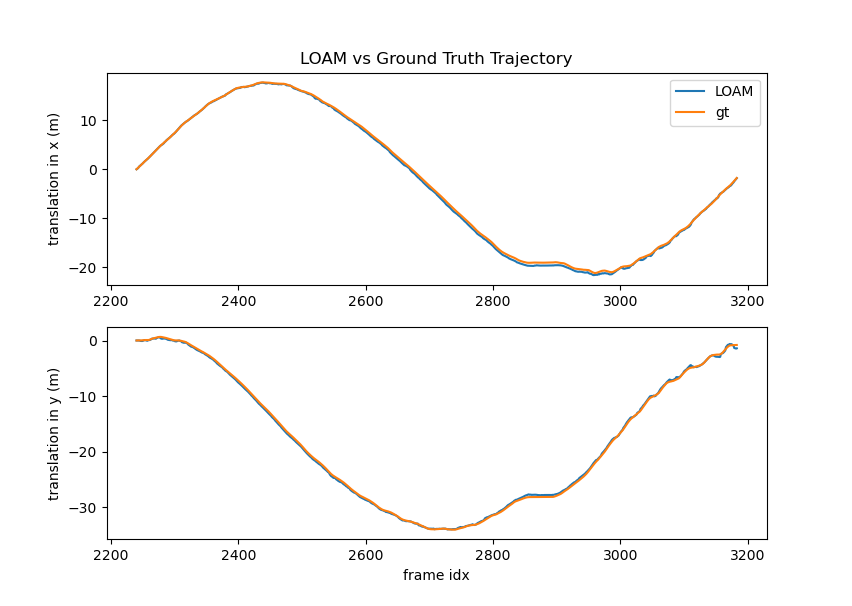

In [635]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].set_title("LOAM vs Ground Truth Trajectory")

x_vec = np.linspace(2240, 2241 + len(LOAM_corr), len(LOAM_corr) )

ax[0].plot(x_vec, LOAM_corr[:,0], label = "LOAM")
ax[0].plot(x_vec, gt_lidarframe[start_idx:end_idx,0], label = "gt")
# ax[0].plot(np.diff(LOAM_corr[:,0]), label = "LOAM")
# ax[0].plot(np.diff(gt_lidarframe[start_idx+1:end_idx,0]), label = "gt")
ax[0].set_ylabel("translation in x (m)")
ax[0].legend(loc='best')
ax[1].set_xlabel("frame idx")
ax[1].set_ylabel("translation in y (m)")
ax[1].plot(x_vec, LOAM_corr[:,1], label = "LOAM")
ax[1].plot(x_vec, gt_lidarframe[start_idx:end_idx,1], label = "gt")
# ax[1].legend(loc='best')

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].set_title("LOAM Error")
ax[0].plot(LOAM_corr[:,0], label = "LOAM")
ax[0].plot(gt_lidarframe[start_idx+1:end_idx,0], label = "gt")
# ax[0].plot(np.diff(LOAM_corr[:,0]), label = "LOAM")
# ax[0].plot(np.diff(gt_lidarframe[start_idx+1:end_idx,0]), label = "gt")
ax[0].set_ylabel("translation in x (m)")
ax[0].legend(loc='best')
ax[1].set_xlabel("frame idx")
ax[1].set_ylabel("translation in y (m)")
ax[1].plot(LOAM_corr[:,1], label = "LOAM")
ax[1].plot(gt_lidarframe[start_idx:end_idx,1], label = "gt")